In [1]:
%matplotlib inline
from __future__ import print_function

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# data directory
DATA_DIR = os.path.join('.', 'data', 'processed')

data_paths = {'A': {'train': os.path.join(DATA_DIR, 'A', 'A_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'A', 'A_hhold_test.csv')}, 
              
              'B': {'train': os.path.join(DATA_DIR, 'B', 'B_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'B', 'B_hhold_test.csv')}, 
              
              'C': {'train': os.path.join(DATA_DIR, 'C', 'C_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'C', 'C_hhold_test.csv')}}

# load training data
a_train = pd.read_csv(data_paths['A']['train'], index_col='id')
b_train = pd.read_csv(data_paths['B']['train'], index_col='id')
c_train = pd.read_csv(data_paths['C']['train'], index_col='id')

In [2]:
# Standardize features
def standardize(df, numeric_only=True):
    numeric = df.select_dtypes(include=['int64', 'float64'])
    
    # subtracy mean and divide by std
    df[numeric.columns] = (numeric - numeric.mean()) / numeric.std()
    
    return df
    

def pre_process_data(df, enforce_cols=None):
    print("Input shape:\t{}".format(df.shape))
        

    df = standardize(df)
    print("After standardization {}".format(df.shape))
        
    # create dummy variables for categoricals
    df = pd.get_dummies(df)
    print("After converting categoricals:\t{}".format(df.shape))
    

    # match test set and training set columns
    if enforce_cols is not None:
        to_drop = np.setdiff1d(df.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, df.columns)

        df.drop(to_drop, axis=1, inplace=True)
        df = df.assign(**{c: 0 for c in to_add})
    
    df.fillna(0, inplace=True)
    
    return df

In [3]:
print("Country A")
aX_train = pre_process_data(a_train.drop('poor', axis=1))
ay_train = np.ravel(a_train.poor)

print("\nCountry B")
bX_train = pre_process_data(b_train.drop('poor', axis=1))
by_train = np.ravel(b_train.poor)

print("\nCountry C")
cX_train = pre_process_data(c_train.drop('poor', axis=1))
cy_train = np.ravel(c_train.poor)

Country A
Input shape:	(8203, 344)
After standardization (8203, 344)
After converting categoricals:	(8203, 859)

Country B
Input shape:	(3255, 441)
After standardization (3255, 441)
After converting categoricals:	(3255, 1432)

Country C
Input shape:	(6469, 163)
After standardization (6469, 163)
After converting categoricals:	(6469, 795)


In [ ]:
# random forests are often a good model to try first, especially when we have numeric and categorical variables in our feature space.

In [4]:
from sklearn.ensemble import RandomForestClassifier

def train_model(features, labels, **kwargs):
    
    # instantiate model
    model = RandomForestClassifier(n_estimators=50, random_state=0)
    
    # train model
    model.fit(features, labels)
    
    # get a (not-very-useful) sense of performance
    accuracy = model.score(features, labels)
    # print(f"In-sample accuracy: {accuracy:0.2%}")
    print("In-sample accuracy: %.2f percent" %(accuracy*100))
    
    return model

In [5]:
# load test data
a_test = pd.read_csv(data_paths['A']['test'], index_col='id')
b_test = pd.read_csv(data_paths['B']['test'], index_col='id')
c_test = pd.read_csv(data_paths['C']['test'], index_col='id')

a_test = pre_process_data(a_test, enforce_cols=aX_train.columns)
b_test = pre_process_data(b_test, enforce_cols=bX_train.columns)
c_test = pre_process_data(c_test, enforce_cols=cX_train.columns)

Input shape:	(4041, 344)
After standardization (4041, 344)
After converting categoricals:	(4041, 851)
Input shape:	(1604, 441)
After standardization (1604, 441)
After converting categoricals:	(1604, 1419)
Input shape:	(3187, 163)
After standardization (3187, 163)
After converting categoricals:	(3187, 773)


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

#This is a RandomForrest Classifier

forest_clf = RandomForestClassifier(random_state=42)
ay_probas_forest = cross_val_predict(forest_clf, aX_train, ay_train, cv=3,
                                    method="predict_proba")

ay_scores_forest = ay_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(ay_train,ay_scores_forest)

In [35]:
#This is a SGD classsifier

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)

ay_probas_sgd = cross_val_predict(sgd_clf, aX_train, ay_train, cv=3)
ay_scores_sgd = cross_val_predict(sgd_clf, aX_train, ay_train, cv=3,
                             method="decision_function")

ay_scores_sgd[:,1]
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(ay_train, ay_scores_sgd[:,1])

//anaconda/envs/DSFP/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [29]:
plot_roc_curve(fpr_sgd, tpr_sgd, "SGD")

In [41]:
#This is a Naive Bayes

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

gnb_clf = GaussianNB()
ay_scores_gnb = cross_val_predict(gnb_clf, aX_train, ay_train, cv=3, method="predict_proba")[:, 1]
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(ay_train,ay_scores_gnb)

In [43]:
#This is an extra Tree classifieer
from sklearn.ensemble import ExtraTreesClassifier

etc_clf = ExtraTreesClassifier(max_features=856, n_estimators=100, min_samples_leaf=10)
ay_scores_etc = cross_val_predict(etc_clf, aX_train, ay_train, cv=3, method="predict_proba")[:, 1]
fpr_etc, tpr_etc, thresholds_etc = roc_curve(ay_train,ay_scores_etc)

In [50]:
#This is an extra Tree classifieer
from sklearn.ensemble import ExtraTreesClassifier

etc_clf_blind = ExtraTreesClassifier()
ay_scores_etc_blind = cross_val_predict(etc_clf_blind, aX_train, ay_train, cv=3, method="predict_proba")[:, 1]
fpr_etc_blind, tpr_etc_blind, thresholds_etc_blind = roc_curve(ay_train,ay_scores_etc_blind)

In [62]:
from sklearn.ensemble import GradientBoostingClassifier
gbg_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)


ay_scores_gbg = cross_val_predict(gbg_clf, aX_train, ay_train, cv=3, method="predict_proba")[:, 1]
fpr_gbg, tpr_gbg, thresholds_gbg = roc_curve(ay_train,ay_scores_gbg)

In [61]:
from sklearn.ensemble import GradientBoostingClassifier

In [48]:
from sklearn import neighbors
knn_clf = neighbors.KNeighborsClassifier()
ay_scores_knn = cross_val_predict(knn_clf, aX_train, ay_train, cv=3, method="predict_proba")[:, 1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(ay_train,ay_scores_knn)

In [54]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier()
ay_scores_mlp = cross_val_predict(mlp_clf, aX_train, ay_train, cv=3, method="predict_proba")[:, 1]
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(ay_train, ay_scores_mlp)

In [ ]:
#This in an ANN

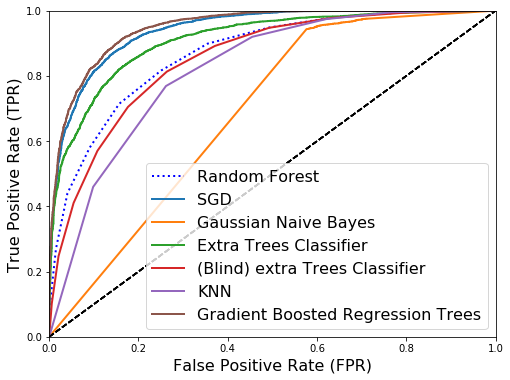

In [64]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(8, 6))
plt.plot(fpr_forest, tpr_forest,'b:', lw = 2.0, label= "Random Forest")
plot_roc_curve(fpr_sgd, tpr_sgd, "SGD")
plot_roc_curve(fpr_gnb, tpr_gnb, "Gaussian Naive Bayes")
plot_roc_curve(fpr_etc, tpr_etc, "Extra Trees Classifier")
plot_roc_curve(fpr_etc_blind, tpr_etc_blind, "(Blind) extra Trees Classifier")
plot_roc_curve(fpr_knn, tpr_knn, "KNN")
plot_roc_curve(fpr_gbg, tpr_gbg, "Gradient Boosted Regression Trees")

plt.legend(loc="lower right", fontsize=16)
plt.savefig('/Users/ioanaciuca/Desktop/trial_algs.pdf', format = 'pdf')

In [ ]:
def do_sgd_pred(X_train, y_train, cv):
    
    sgd_clf = SGDClassifier(random_state=42)
    y_probas_sgd = cross_val_predict(sgd_clf, X_train, y_train, cv = cv)
    y_scores_sgd = cross_val_predict(sgd_clf, X_train, y_train, cv = cv,
                             method="decision_function")
    
    return y_probas_sgd, y_scores_sgd

def do_forrest_pred(X_train, y_train, cv):
    
    forrest_clf = RandomForestClassifier(random_state=42)
    y_probas_forrest = cross_val_predict(forrest_clf, X_train, y_train, cv=cv,
                                    method="predict_proba")

    y_scores_forrest = y_probas_forrest[:, 1]
    
    return y_probas_forrest, y_scores_forrest

ay_probas_sgd, ay_scores_sgd = do_sgd_pred(aX_train, ay_train, cv = 3)
ay_probas_forrest, ay_scores_forrest = do_forrest_pred(aX_train, ay_train, cv = 3)


def train_SGD_model(features, labels, **kwargs):
    
    # instantiate model
    model = SGDClassifier(loss = 'log', penalty = 'l2', random_state=42)
    
    # train model
    model.fit(features, labels)
    
    # get a (not-very-useful) sense of performance
    accuracy = model.score(features, labels)
    # print(f"In-sample accuracy: {accuracy:0.2%}")
    print("In-sample accuracy: %.2f percent" %(accuracy*100))
    
    return model

def train_RFC_model(features, labels, **kwargs):
    
    # instantiate model
    model = RandomForestClassifier(n_estimators=50, random_state=0)
    
    # train model
    model.fit(features, labels)
    
    # get a (not-very-useful) sense of performance
    accuracy = model.score(features, labels)
    # print(f"In-sample accuracy: {accuracy:0.2%}")
    print("In-sample accuracy: %.2f percent" %(accuracy*100))
    
    return model

model_sgd_a = train_SGD_model(aX_train, ay_train)
model_sgd_b = train_SGD_model(bX_train, by_train)
model_sgd_c =  train_SGD_model(cX_train, cy_train)

In [27]:
fpr_sgd

array([  0.00000000e+00,   0.00000000e+00,   2.22222222e-04, ...,
         7.33111111e-01,   7.33111111e-01,   1.00000000e+00])

In [ ]:
def do_sgd_pred(X_train, y_train, cv):
    
    sgd_clf = SGDClassifier(random_state=42)
    y_probas_sgd = cross_val_predict(sgd_clf, X_train, y_train, cv = cv)
    y_scores_sgd = cross_val_predict(sgd_clf, X_train, y_train, cv = cv,
                             method="decision_function")
    
    return y_probas_sgd, y_scores_sgd

ay_probas_sgd, ay_scores_sgd =  do_sgd_pred(aX_train, ay_train, cv = 3)
ay_scores_sgd

In [ ]:
model_forresr_a = train_RFC_model(aX_train, ay_train)
model_forrest_b = train_RFC_model(bX_train, by_train)
model_forrest_c =  train_RFC_model(cX_train, cy_train)

In [ ]:
# ANOTHER METHOD....

In [ ]:
# Feature Importance
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

# fit an Extra Trees model to the data
model2 = ExtraTreesClassifier()
model2.fit(X_test1, y_test1)
# display the relative importance of each attribute
# print(model.feature_importances_)
np.sum(model2.feature_importances_ > 1e-3)

In [ ]:
cutoff = 1e-4
np.sum(model2.feature_importances_ > cutoff)

In [ ]:
model = train_model(X_train.loc[:, model2.feature_importances_ > cutoff], y_train)

In [ ]:
preds = model.predict_proba(X_test2.loc[:, model2.feature_importances_ > cutoff])

In [ ]:
score = model.score(X_test2.loc[:, model2.feature_importances_ > cutoff], y_test2)

In [ ]:
score